In [1]:
#1 Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from config import BASE_DIR
from scipy.cluster.hierarchy import dendrogram,  fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.spatial.distance
import import_ipynb 
import pickle
 
from extract_info import vect2cid, cid2vect
from bTree import Node

importing Jupyter notebook from extract_info.ipynb
importing Jupyter notebook from bTree.ipynb


In [2]:
dataset = pd.read_csv(f'{BASE_DIR}/VECTORIZED_CSV/vectors_list.csv',header=None)
#csv file has no header, we have to define header=None. Oterwise first column used as a header.

#3 Using the dendrogram to find the optimal numbers of clusters. # First thing we're going to do is to import scipy
# library. scipy is #an open source Python library that contains tools to do #hierarchical clustering and building
# dendrograms. Only import the #needed tool. import scipy.cluster.hierarchy as sch #Lets create a dendrogram variable
# linkage is actually the algorithm #itself of hierarchical clustering and then in linkage we have to #specify on
# which data we apply and engage. This is X dataset dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
# plt.title('Dendrogram') plt.xlabel('Compounds') plt.ylabel('Euclidean distances') plt.show()


#4 Fitting hierarchical clustering to the Mall_Customes dataset # There are two algorithms for hierarchical
# clustering: #Agglomerative Hierarchical Clustering and # Divisive Hierarchical Clustering. We choose Euclidean
# distance and ward method for our algorithm class from sklearn.cluster import AgglomerativeClustering hc =
# AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward') # Lets try to fit the hierarchical
# clustering algorithm  to dataset #X while creating the clusters vector that tells for each customer #which cluster
# the customer belongs to. y_hc=hc.fit_predict(X)
 
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)  
    
    for i, merge in enumerate(model.children_):
        current_count = 0  
        for child_idx in merge:           
            if child_idx < n_samples:
                current_count += 1  # leaf node  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count   
      
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram ; 120 
    dendrogram(linkage_matrix, color_threshold=110, **kwargs)
    return linkage_matrix
    
def generate_cluster(dataset):
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,compute_full_tree=True)
    model = model.fit(dataset)
    plt.figure(figsize=(20,10))
    plt.title('Hierarchical Clustering of Mol2Vec Embedded Compounds')
    # plot the top three levels of the dendrogram
    #levels of the dendrogram are index of dataset
    linkageMatrix = plot_dendrogram(model)
    plt.xlabel("Index")
    plt.ylabel("Linkage Distance")
    plt.show() 
    return linkageMatrix,model.n_leaves_


In [3]:
# Store linkage Matrix  into a pkl file, this is only for saving time when working, 
# otherwise we need to construct liankage matrix all the time
def store_linkageMatrix(linkageMatrix):
    filename = 'linkageMatrix.pkl'
    outfile = open(filename,'wb+')
    pickle.dump(linkageMatrix,outfile)
    outfile.close 

In [4]:
def get_linkageMatrix():
    # load mapping
    infile = open(BASE_DIR+'/linkageMatrix.pkl', 'rb')
    mapping = pickle.load(infile)
    infile.close() 
    return (mapping) 

In [5]:
#replace dataset index with compound id
# index_cid consist of key value pair . Here key is dataset index and value is Cid
def store_cid_indexId(dataset):
    index_cid = {} 
    for index in range(len(dataset)):
        dataitem = dataset.loc[index].tolist() # read vector from datasset 
        index_cid[index] = vect2cid([ dataitem)])
    return index_cid
    
    
'''
 extract cid from index
 input : list of dataset index
 output: list of cid
'''
def get_cid_from_index(ids):
    cids = []
    for index in ids:
        cids.append(index_cid[index])
    return cids

In [6]:
#we need to generate a binary tree same as dendrogram, we need to track child alignment. Here we store alignment information in "tree_helper" dictionary
# input : linkage matrix, no of compound
# output: dictionary which contain partial information of child alignment
# key of this dictionary is id of compound or cluster, linkage matrix provide unique id for each cluster
# yet we don't know , which compounds are inside cluster, we will update this dictionary with cluster compounds later
def compute_a_helper_to_genarate_tree(linkageMatrix,no_of_leaves):
    tree_helper = {} 
    for idx in linkageMatrix:
        left_child = int(idx.tolist()[0])
        right_child = int(idx.tolist()[1]) 

        if left_child < no_of_leaves:
            tree_helper[left_child] = [[left_child], 'l']
        else:
            # set new cluster position, without cluster items
            tree_helper[left_child] = [[], 'l']
        if right_child < no_of_leaves:
            tree_helper[right_child] = [[right_child], 'r']
        else:
            tree_helper[right_child] = [[], 'r']

    return tree_helper

In [7]:
# cut dendrogram at each joining poit
#linkage matrix [item1 item2 distance number_of_cluster_items]
# convert dataframe to list items using tolist()
# dis.tolist()[2] : represent linkage  distance, cut the dendrogram at this level
# dis.tolist()[3] : represent number of items of new cluster.
# We will avoid to cut, where new cluster has 2 items. We need atleast 3 items to find a medoid in cluster  
# In dict_cluster, key -> cluster id, value -> cluster items list
# In dict_clusters, key -> distance, value -> clusters and leafs
def cut_dendrogram_in_joining_distance(linkageMatrix,no_of_leaves):    
    dict_clusters = {} 
    num = no_of_leaves
    clusterList = []
    for dis in linkageMatrix:
        #if dis.tolist()[3] > 2:  
        # dis.tolist()[3] > 2: first we avoid cut where 2 items create a cluster
        # to create a tree, we need all leaf node. that why need to cut each joining point
        
        clusters = fcluster(linkageMatrix, dis.tolist()[2], criterion='distance') 
        dict_cluster = {}
        i=0 
        for x in clusters:
            temp = dict_cluster.get(x) 

            if temp is None:
                temp = [i]
            else:
                temp.append(i)

            dict_cluster[x] = temp
            i=i+1 
            
        # track new cluster and update tree_helper with cluster items
        for id in dict_cluster: 
            new_cluster = dict_cluster.get(id) 
            if len(new_cluster) > 1 and new_cluster not in clusterList:
                helper_item = tree_helper.get(num)
                if helper_item != None and helper_item[0] == []:
                    helper_item[0] = new_cluster
                    tree_helper[num] = helper_item
                    clusterList.append(new_cluster)            
                    num +=1
            
                         
        dict_clusters[dis.tolist()[2]] = dict_cluster       
            
    return dict_clusters

In [8]:
# simplify tree helper dict to list, that will minimize search for position 
def simplify_helperList(tree_helper):
    tree_helperList = []
    for idx in tree_helper:
        cluster_info = tree_helper.get(idx)
        if cluster_info[1] == 'l':
            tree_helperList.append(cluster_info[0])
    return tree_helperList

In [9]:
'''
 extract medoid from cluster
 input: set of vectors
 output: cid of medoid 
'''
def get_medoid_from_cluster(cluster):
    Y = scipy.spatial.distance.cdist(cluster, cluster, 'euclidean')
    minidx = np.argmin(Y.sum(axis=0))
    medvect = np.asarray(cluster[minidx])
    cid = vect2cid([medvect]) #retrive compound id for this vector
    return cid

In [10]:
# input : dict of clusters
# output : dict of cluster id -> [medoid,cluster items,parent]
def get_medoids_from_clusters(dict_clusters):
    cluster_id = 0
    dict_medoid = {} 
    prev_cut_clusters = {}
    parent = None 

    # reverse keys, to compute medoid of one cluster first. That will root for binary tree
    keys = list(dict_clusters.keys())
    keys.reverse() 
    #print(keys)

    for cluster_key in keys:
        clusters_list = dict_clusters.get(cluster_key)
        for cluster in clusters_list: 
            cluster_list = clusters_list.get(cluster)

            # check if cluster alrady calculate medoid 
            match = 0
            medoid = None
            for id in prev_cut_clusters:
                if prev_cut_clusters[id] == cluster_list:
                    match = 1
                    break 
            # calculate medoid when cluster has at least 3 items and did not compute medoid yet        
            if len(cluster_list) > 2 and match == 0:
                temp_cluster = []
                for dataid in cluster_list: 
                    item = dataset.loc[dataid].tolist()
                    temp_cluster.append(item)
                
                medoid = get_medoid_from_cluster(temp_cluster) 
            
            if match == 0:
                pos = None
                #set cluster position in tree 
                if cluster_list in tree_helperList: 
                    pos = 'l'
                else:
                    pos = 'r' 

                cid_list = get_cid_from_index(cluster_list)
                # find cluster parent
                # Check set_m  is a sub set of set_n, set(n) & set(m) == set(m)
                # set_n is parent of set_m iff set_m is a  sub set if set_n
                for x in range(cluster_id-1,-1,-1): 
                    if set(dict_medoid['C'+str(x)][1]) & set(cid_list) == set(cid_list):
                        parent = 'C'+str(x) 
                        break 
                # cluster of  items and leaf node medoid set as a None 
                dict_medoid['C'+str(cluster_id)] = [medoid, cid_list,parent,pos]
                cluster_id +=1
        prev_cut_clusters = clusters_list
         
    return dict_medoid
        
        
# multiple custers may have same medoid. i.e 
#    'C0': [19,[1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9], None],
#    'C6': [19, [12, 17, 18, 19, 20, 21, 3, 5, 8], 'C2'],
#    'C8': [19, [12, 17, 19, 20, 3], 'C6'], 
#    'C11': [19, [12, 19, 20], 'C8']}
     

In [11]:
def store_medoid_list(dict_medoid):
    filename = 'medoid_cluster_dict.pkl'
    outfile = open(filename,'wb+')
    pickle.dump(dict_medoid,outfile)
    outfile.close   

In [12]:
# insert clusters into a tree
def insert_cluster_into_tree(dict_medoid):
    for node_id in dict_medoid:
        node = dict_medoid.get(node_id)
        if node[2] == None:
            root = Node(node_id,node) 
        else:
            root.insert(node_id,node) 
    return root

In [13]:
def store_tree(tree):
    filename = 'medoid_cluster_tree.pkl'
    outfile = open(filename,'wb+')
    pickle.dump(tree,outfile)
    outfile.close 

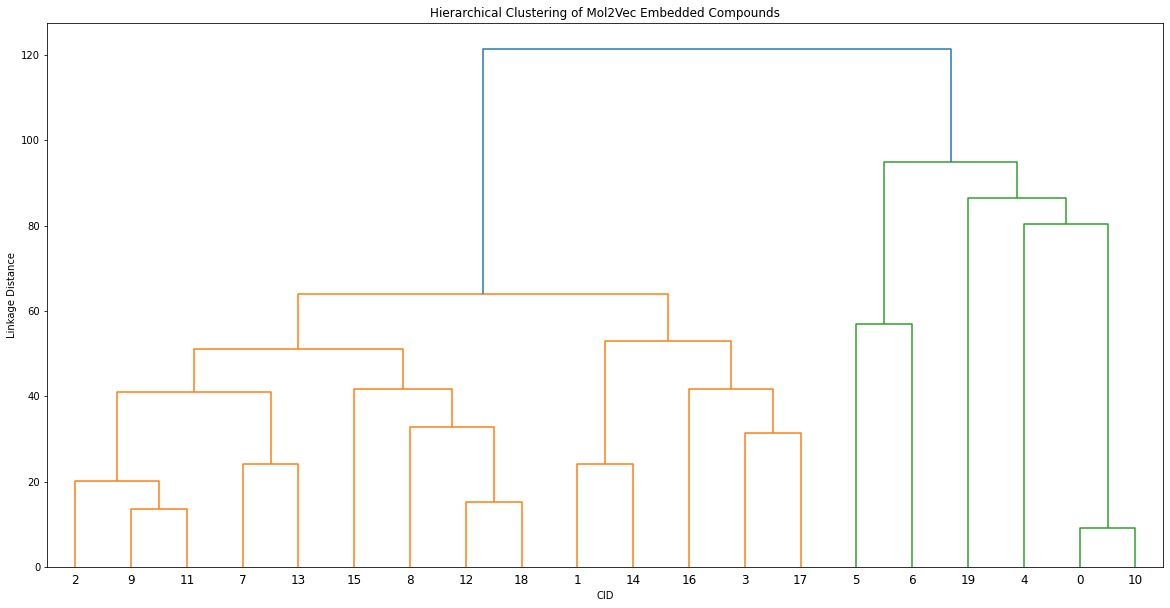

In [14]:
linkageMatrix,no_of_leaves = generate_cluster(dataset) 

In [15]:
#store_linkageMatrix(linkageMatrix)

In [16]:
#linkageMatrix = getlinkageMatrix()
#linkageMatrix

In [17]:
index_cid = store_cid_indexId(dataset)
tree_helper =  compute_a_helper_to_genarate_tree(linkageMatrix,no_of_leaves)

In [18]:
dict_clusters =  cut_dendrogram_in_joining_distance(linkageMatrix,no_of_leaves) 

In [19]:
#len(dict_clusters)

In [20]:
tree_helperList = simplify_helperList(tree_helper)

In [21]:
dict_medoid = get_medoids_from_clusters(dict_clusters)

In [22]:
#dict_medoid

In [23]:
store_medoid_list(dict_medoid)

In [24]:
root = insert_cluster_into_tree(dict_medoid)

In [25]:
# tree representation of clusters
#root.PrintTree()

In [26]:
store_tree(root)

In [ ]:
infile = open(BASE_DIR+'/medoid_cluster_tree.pkl', 'rb')
tree = pickle.load(infile)
infile.close() 
tree.PrintTree()